In [14]:
print('hello world')

hello world


In [2]:
! pip install torch torch-geometric rdkit deepchem pandas numpy matplotlib

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.0 MB/s eta 0:00:00a 0:00:01


In [15]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from torch_geometric.data import Data
from deepchem.molnet import load_toxcast
import torch

# Load ToxCast dataset
toxcast_tasks, datasets, transformers = load_toxcast(split='stratified')
train_dataset, valid_dataset, test_dataset = datasets

# Convert first 1000 molecules (for demo) to PyTorch Geometric format
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None

    # Atom features (example: atomic number)
    atom_features = [[atom.GetAtomicNum()] for atom in mol.GetAtoms()]

    # Bonds as edge indices
    edge_index = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.extend([(i, j), (j, i)])  # Undirected graph

    # Assay labels (using first task: NR-AR)
    label = train_dataset.y[0][0]  # Binary activity for NR-AR assay

    return Data(x=torch.tensor(atom_features, dtype=torch.float),
                edge_index=torch.tensor(edge_index).t().contiguous(),
                y=torch.tensor([label], dtype=torch.float))

# Create graph dataset
graph_data = [smiles_to_graph(smiles) for smiles in train_dataset.ids[:1000]]
graph_data = [g for g in graph_data if g is not None]  # Remove invalid


'split' is deprecated.  Use 'splitter' instead.


=== Basic Dataset Overview ===
Total chemicals: 6,863
Total assays/endpoints: 617
Missing values: 0 (0.00%)

=== Chemical Property Analysis ===


[01:58:12] WARNING: not removing hydrogen atom without neighbors


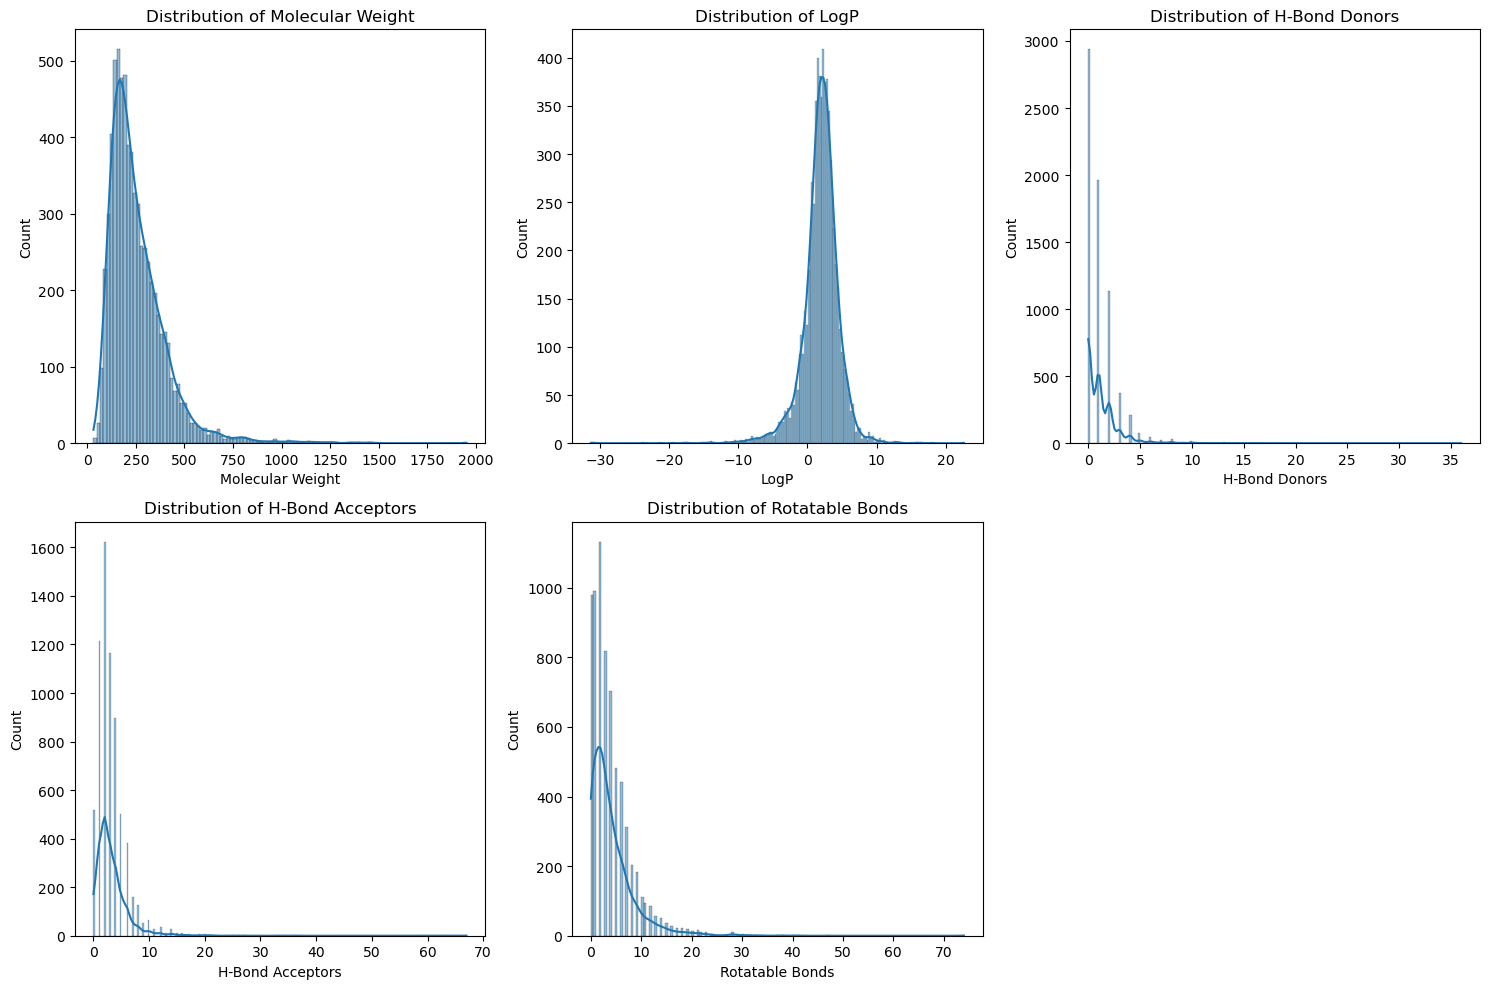


=== Assay Activity Summary ===

Top 10 Most Active Assays:
                                     mean       std  active_ratio
ATG_PXRE_CIS_up                  0.196707  0.397538      0.196707
TOX21_ARE_BLA_agonist_ratio      0.179805  0.384053      0.179805
TOX21_TR_LUC_GH3_Antagonist      0.177182  0.381850      0.177182
ATG_NRF2_ARE_CIS_up              0.151829  0.358881      0.151829
TOX21_ERa_LUC_BG1_Agonist        0.150080  0.357176      0.150080
TOX21_Aromatase_Inhibition       0.131429  0.337894      0.131429
TOX21_AR_LUC_MDAKB2_Antagonist2  0.125310  0.331094      0.125310
TOX21_AR_BLA_Antagonist_ratio    0.121813  0.327093      0.121813
ATG_PXR_TRANS_up                 0.113653  0.317412      0.113653
TOX21_p53_BLA_p2_ratio           0.111176  0.314373      0.111176

Top 10 Least Active Assays:
                                   mean       std  active_ratio
CLD_ABCG2_48hr                 0.001749  0.041782      0.001749
BSK_4H_Pselectin_up            0.001894  0.043485      0.

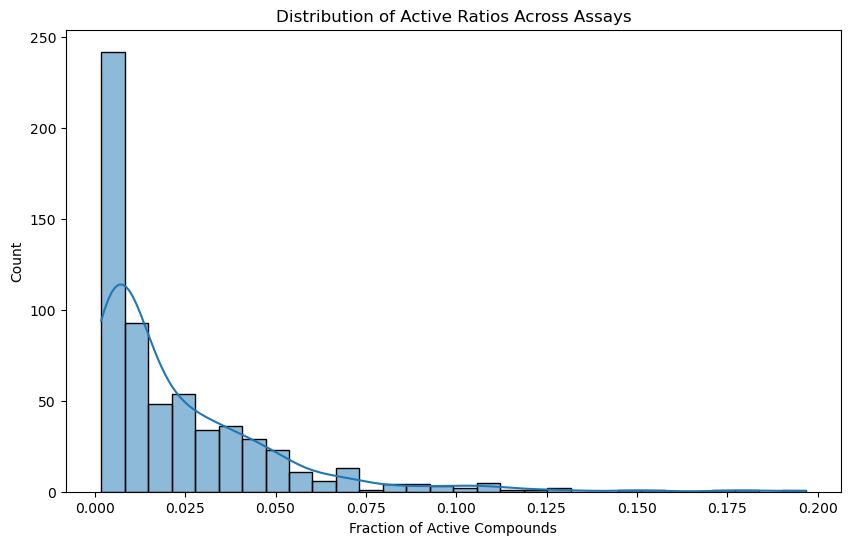


=== Structure-Activity Relationships ===
Active compounds (>50% assay activity): 0
Inactive compounds (<10% assay activity): 6399


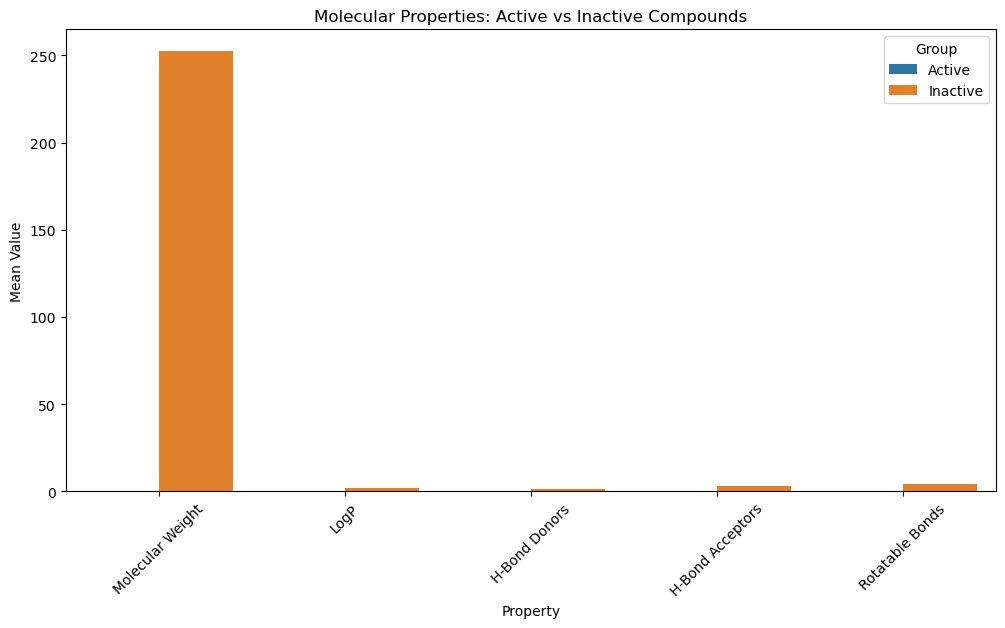


=== Assay Correlation Analysis ===


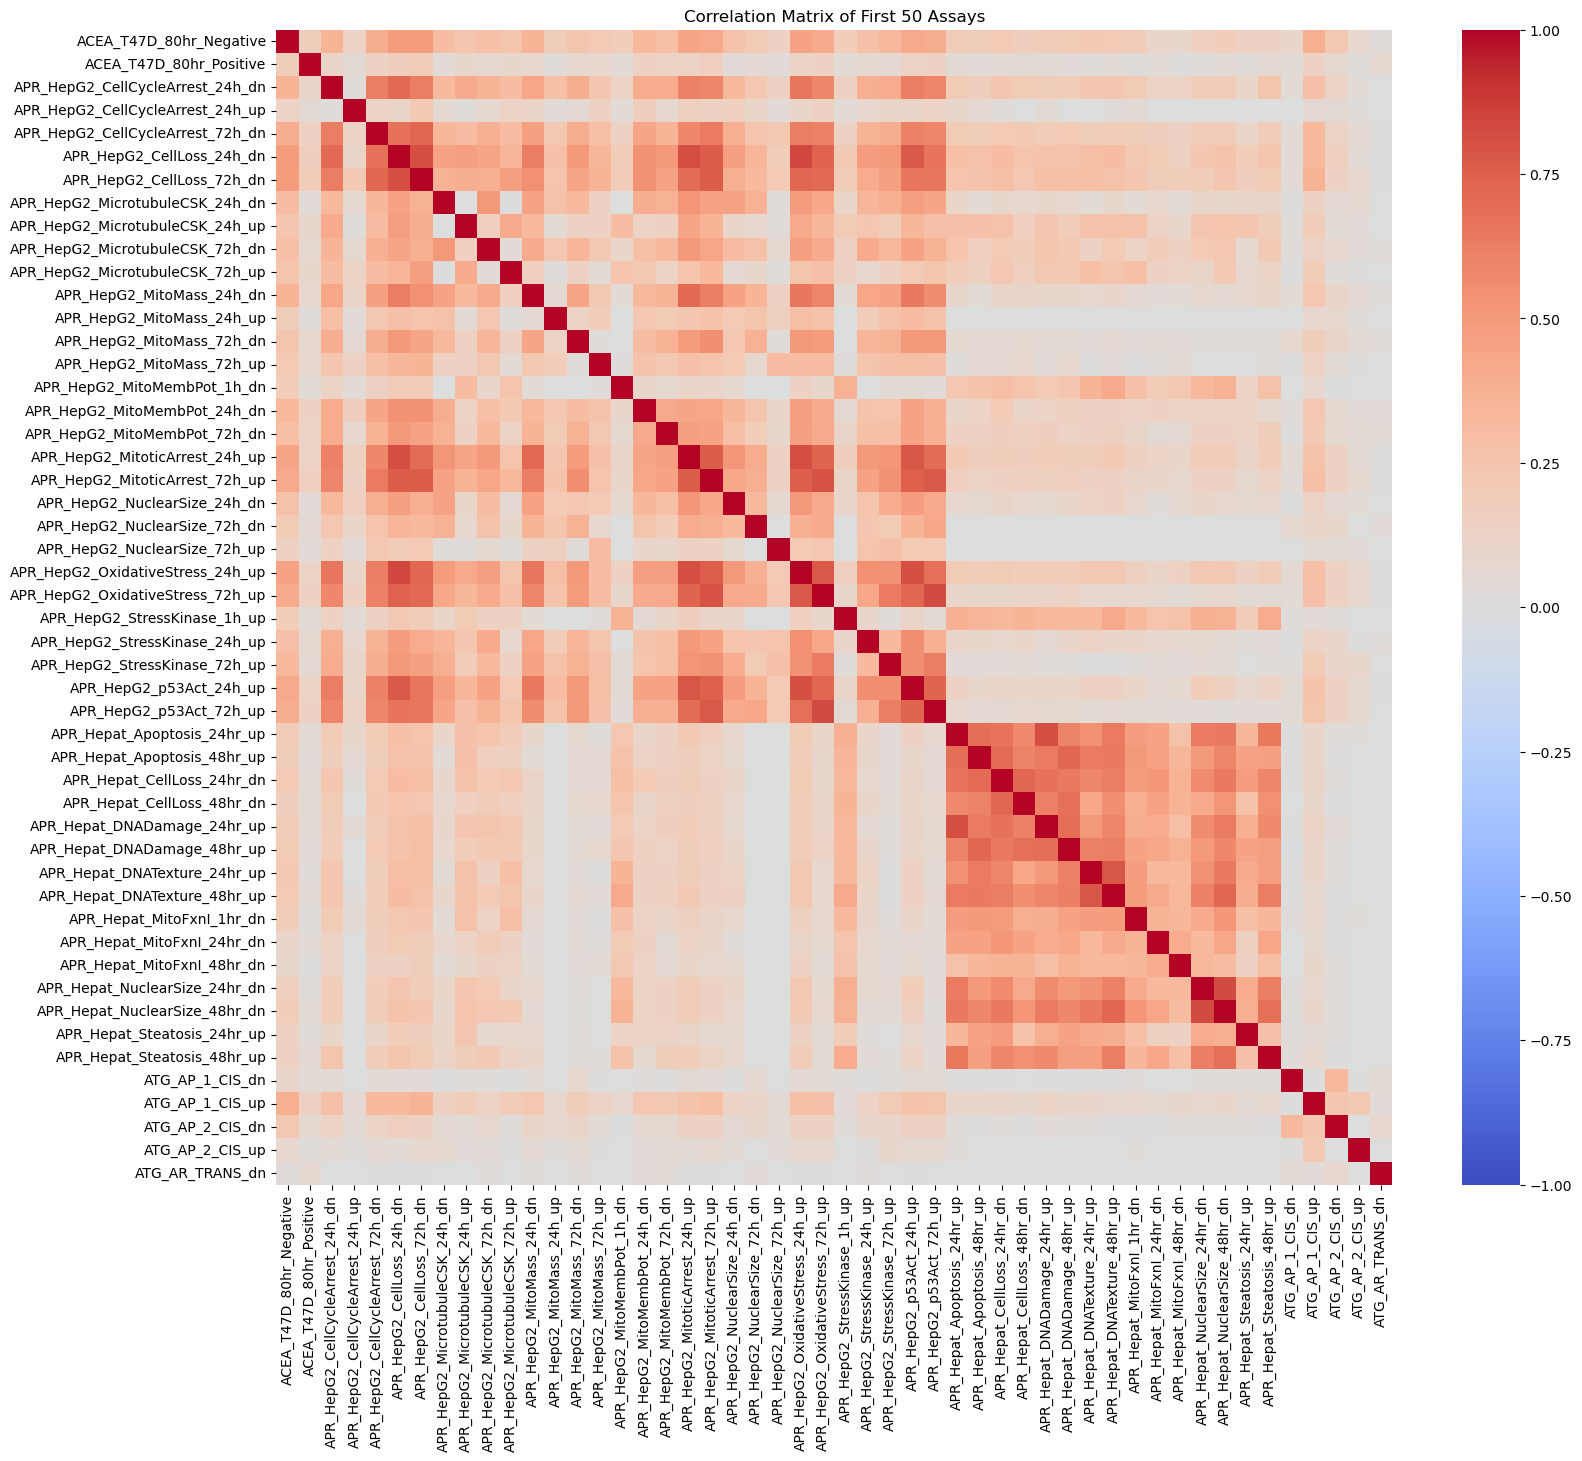


=== Chemical Space Visualization ===
Error in chemical space visualization: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).


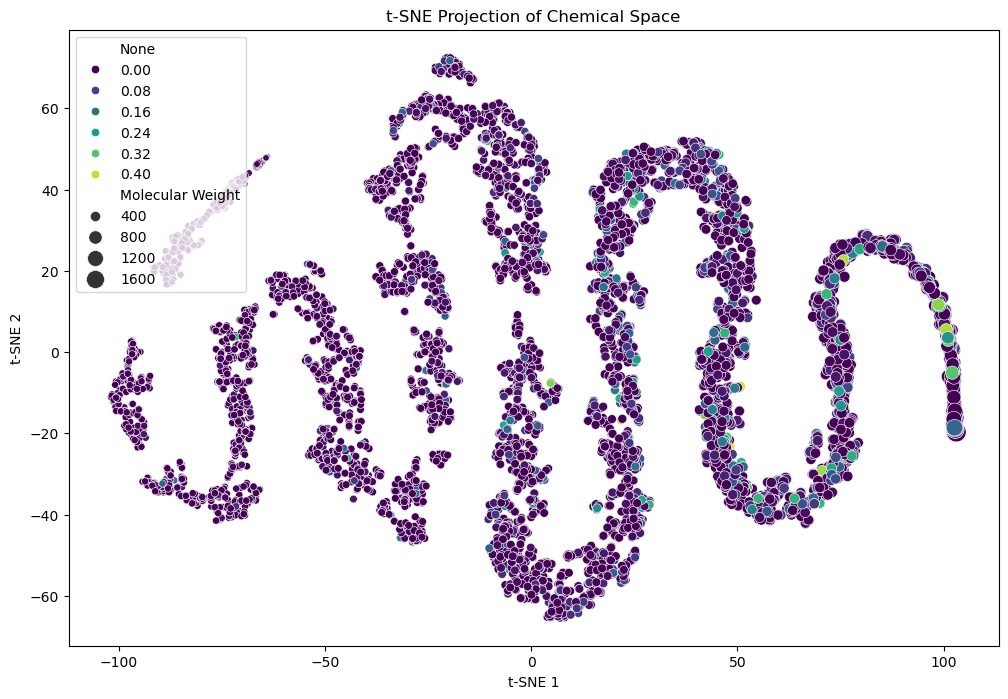

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors
from deepchem.molnet import load_toxcast
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE

# Load dataset with proper error handling
try:
    toxcast_tasks, datasets, transformers = load_toxcast(
        featurizer='Raw',
        splitter='scaffold',
        reload=True
    )
    train_dataset, valid_dataset, test_dataset = datasets
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

# Create DataFrame with assay results
df = pd.DataFrame(
    data=train_dataset.y,
    columns=toxcast_tasks,
    index=train_dataset.ids
)
df['SMILES'] = train_dataset.ids

# Basic Dataset Exploration
print("=== Basic Dataset Overview ===")
print(f"Total chemicals: {len(df):,}")
print(f"Total assays/endpoints: {len(toxcast_tasks)}")
print(f"Missing values: {df[toxcast_tasks].isna().sum().sum():,} ({(df[toxcast_tasks].isna().sum().sum()/(len(df)*len(toxcast_tasks)))*100:.2f}%)")

# Chemical Property Analysis with RDKit
def compute_molecular_properties(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return {
                'Molecular Weight': Descriptors.MolWt(mol),
                'LogP': Descriptors.MolLogP(mol),
                'H-Bond Donors': Descriptors.NumHDonors(mol),
                'H-Bond Acceptors': Descriptors.NumHAcceptors(mol),
                'Rotatable Bonds': Descriptors.NumRotatableBonds(mol)
            }
        return None
    except:
        return None

print("\n=== Chemical Property Analysis ===")
props = df['SMILES'].apply(compute_molecular_properties).dropna().apply(pd.Series)
df = pd.concat([df, props], axis=1).dropna(subset=props.columns)

# Plot chemical property distributions
props_to_plot = ['Molecular Weight', 'LogP', 'H-Bond Donors', 'H-Bond Acceptors', 'Rotatable Bonds']
plt.figure(figsize=(15, 10))
for i, prop in enumerate(props_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[prop], kde=True)
    plt.title(f'Distribution of {prop}')
plt.tight_layout()
plt.show()

# Assay Activity Analysis
print("\n=== Assay Activity Summary ===")
assay_stats = df[toxcast_tasks].describe().T
assay_stats['active_ratio'] = df[toxcast_tasks].mean()
assay_stats['missing_ratio'] = df[toxcast_tasks].isna().mean()

print("\nTop 10 Most Active Assays:")
print(assay_stats.nlargest(10, 'active_ratio')[['mean', 'std', 'active_ratio']])

print("\nTop 10 Least Active Assays:")
print(assay_stats.nsmallest(10, 'active_ratio')[['mean', 'std', 'active_ratio']])

plt.figure(figsize=(10, 6))
sns.histplot(assay_stats['active_ratio'], bins=30, kde=True)
plt.title('Distribution of Active Ratios Across Assays')
plt.xlabel('Fraction of Active Compounds')
plt.show()

# Structure-Activity Relationships with error handling
print("\n=== Structure-Activity Relationships ===")
try:
    active_threshold = 0.5
    inactive_threshold = 0.1

    active_mask = df[toxcast_tasks].mean(axis=1) > active_threshold
    inactive_mask = df[toxcast_tasks].mean(axis=1) < inactive_threshold

    print(f"Active compounds (>50% assay activity): {active_mask.sum()}")
    print(f"Inactive compounds (<10% assay activity): {inactive_mask.sum()}")

    # Comparison with numpy concatenate fix
    comparison_data = np.concatenate([
        df[active_mask][props_to_plot].mean().values,
        df[inactive_mask][props_to_plot].mean().values
    ])

    comparison_df = pd.DataFrame({
        'Property': props_to_plot * 2,
        'Group': ['Active']*5 + ['Inactive']*5,
        'Mean Value': comparison_data
    })

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Property', y='Mean Value', hue='Group', data=comparison_df)
    plt.title('Molecular Properties: Active vs Inactive Compounds')
    plt.xticks(rotation=45)
    plt.show()

except Exception as e:
    print(f"Error in structure-activity analysis: {e}")

# Assay Correlation Analysis
print("\n=== Assay Correlation Analysis ===")
try:
    imputer = SimpleImputer(strategy='constant', fill_value=0)
    assay_matrix = imputer.fit_transform(df[toxcast_tasks[:50]])

    plt.figure(figsize=(18, 15))
    sns.heatmap(pd.DataFrame(assay_matrix, columns=toxcast_tasks[:50]).corr(),
                cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix of First 50 Assays')
    plt.show()
except Exception as e:
    print(f"Error in correlation analysis: {e}")

# Chemical Space Visualization
print("\n=== Chemical Space Visualization ===")
try:
    tsne = TSNE(n_components=2, random_state=42)
    chemical_embeddings = tsne.fit_transform(df[props_to_plot])

    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=chemical_embeddings[:,0], y=chemical_embeddings[:,1],
                    hue=df[toxcast_tasks].mean(axis=1), palette='viridis',
                    size=df['Molecular Weight'], sizes=(20, 200))
    plt.title('t-SNE Projection of Chemical Space')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.colorbar(label='Mean Assay Activity')
    plt.show()
except Exception as e:
    print(f"Error in chemical space visualization: {e}")


In [10]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class ToxGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GATConv(in_channels=1, out_channels=32)  # Atom features: atomic number
        self.attn = GATConv(32, 1)  # Attention layer for interpretation
        self.classifier = torch.nn.Linear(32, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First GAT layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        # Attention layer (weights used for interpretation)
        attn_weights = self.attn(x, edge_index)

        # Global mean pooling
        x = torch.mean(x, dim=0)  # Combine atom features

        # Classification
        out = self.classifier(x)
        return torch.sigmoid(out), attn_weights


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ToxGNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Simplified training loop
for epoch in range(10):
    model.train()
    total_loss = 0
    for graph in graph_data:
        graph = graph.to(device)
        optimizer.zero_grad()
        pred, _ = model(graph)
        loss = F.binary_cross_entropy(pred, graph.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}, Loss: {total_loss/len(graph_data):.4f}")


IndexError: index 0 is out of bounds for dimension 0 with size 0

In [16]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv

# Modified graph creation function
def smiles_to_graph(smiles, idx, task_index=0):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None

    # Get atom features (add more features for better performance)
    atom_features = [
        [atom.GetAtomicNum(),  # Basic atom features
         atom.GetDegree(),
         atom.GetHybridization().real]
        for atom in mol.GetAtoms()
    ]

    # Create edge indices
    edge_index = []
    for bond in mol.GetBonds():
        start = bond.GetBeginAtomIdx()
        end = bond.GetEndAtomIdx()
        edge_index.extend([(start, end), (end, start)])  # Undirected edges

    # Skip molecules with no bonds
    if not edge_index:
        return None

    # Get correct label for this molecule and task
    try:
        label = train_dataset.y[idx][task_index]
    except IndexError:
        return None

    return Data(
        x=torch.tensor(atom_features, dtype=torch.float),
        edge_index=torch.tensor(edge_index).t().contiguous(),
        y=torch.tensor([label], dtype=torch.float)
    )

# Create graph dataset with proper filtering
task_index = 0  # Select first assay task
graph_data = []
for idx, smiles in enumerate(train_dataset.ids[:1000]):
    graph = smiles_to_graph(smiles, idx, task_index)
    if graph is not None and len(graph.edge_index) > 0:  # Filter empty graphs
        graph_data.append(graph)

print(f"Valid graphs: {len(graph_data)}/{len(train_dataset.ids[:1000])}")

# Modified GNN model
class ToxGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GATConv(in_channels=3, out_channels=32)  # Match input features
        self.attn = GATConv(32, 1)
        self.classifier = torch.nn.Linear(32, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Add self-loops to prevent empty edge indices
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        # Global mean pooling with fallback
        if x.size(0) > 0:
            x = torch.mean(x, dim=0)
        else:
            x = torch.zeros(32).to(x.device)

        return torch.sigmoid(self.classifier(x)), None  # Simplified for demonstration

# Training with empty graph check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ToxGNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    total_loss = 0
    valid_count = 0

    for graph in graph_data:
        if len(graph.edge_index) == 0:  # Final validation check
            continue

        graph = graph.to(device)
        optimizer.zero_grad()
        pred, _ = model(graph)

        if not torch.isnan(graph.y).any():  # Handle missing labels
            loss = F.binary_cross_entropy(pred, graph.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            valid_count += 1

    if valid_count > 0:
        print(f"Epoch {epoch}, Loss: {total_loss/valid_count:.4f}")
    else:
        print(f"Epoch {epoch}: No valid graphs")


Valid graphs: 997/1000
Epoch 0, Loss: 0.2126
Epoch 1, Loss: 0.1826
Epoch 2, Loss: 0.1821
Epoch 3, Loss: 0.1818
Epoch 4, Loss: 0.1815
Epoch 5, Loss: 0.1815
Epoch 6, Loss: 0.1812
Epoch 7, Loss: 0.1810
Epoch 8, Loss: 0.1811
Epoch 9, Loss: 0.1808
